# Brain Tumor Detection

## Machine learning model using Resnet-18

In [1]:
#library
import os 
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
print("all modules implemented")

all modules implemented


In [2]:
#transform given input
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

In [3]:
#data preparing
tumordata_dir = r'D:\ml\brain tumor'
image_datasets = {x: datasets.ImageFolder(os.path.join(tumordata_dir, x), data_transforms[x]) for x in ['train', 'val']}

In [4]:
#dataloading
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True) for x in ['train', 'val']}


In [5]:
#implementing resnet model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features # extracting the number of input features
model.fc = nn.Linear(num_ftrs, 2) #2, specifies the number of output units in the new FC layer ("yes" and "no")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

C:\Users\jishn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\jishn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
criterion = nn.CrossEntropyLoss() #  loss function for training classification models
optimizer = optim.Adam(model.parameters(), lr=0.001) #lr is learning rate
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # learning rate scheduler

In [7]:
# Training and validation loop
num_epochs = 5
best_acc = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloaders['train'])
    print(f'Epoch [{epoch+1}/{num_epochs}], training Loss: {epoch_loss:.4f}')
    
    scheduler.step()  # Update the learning rate
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
        
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(dataloaders['val'])
    accuracy = correct / total * 100

    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.2f}%")

    # Save the best model
    if accuracy > best_acc:
        best_acc = accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved")

Epoch [1/5], training Loss: 0.3166
Validation Loss: 0.1668
Validation Accuracy: 93.02%
Best model saved
Epoch [2/5], training Loss: 0.1821
Validation Loss: 0.5026
Validation Accuracy: 83.86%
Epoch [3/5], training Loss: 0.1393
Validation Loss: 0.2330
Validation Accuracy: 88.68%
Epoch [4/5], training Loss: 0.1261
Validation Loss: 0.1858
Validation Accuracy: 92.75%
Epoch [5/5], training Loss: 0.0861
Validation Loss: 0.1921
Validation Accuracy: 93.22%
Best model saved


In [8]:
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, dataloaders, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=image_datasets['val'].classes)

    return cm, report

cm, report = evaluate_model(model, dataloaders, device)
print('Confusion Matrix:')s
print(cm)
print('Classification Report:')
print(report)


Confusion Matrix:
[[493   0]
 [100 882]]
Classification Report:
              precision    recall  f1-score   support

          no       0.83      1.00      0.91       493
         yes       1.00      0.90      0.95       982

    accuracy                           0.93      1475
   macro avg       0.92      0.95      0.93      1475
weighted avg       0.94      0.93      0.93      1475



## Computer Vision using Grad-Cam


Confusion Matrix:
[[493   0]
 [100 882]]
Classification Report:
              precision    recall  f1-score   support

          no       0.83      1.00      0.91       493
         yes       1.00      0.90      0.95       982

    accuracy                           0.93      1475
   macro avg       0.92      0.95      0.93      1475
weighted avg       0.94      0.93      0.93      1475



C:\Users\jishn\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


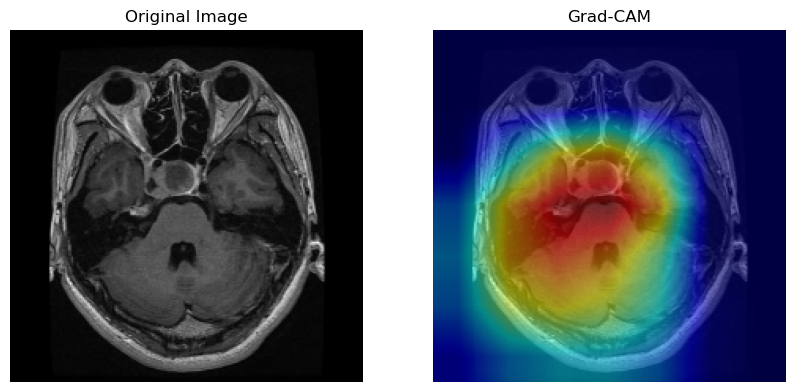

In [10]:
# Grad-CAM function
def grad_cam(model, img_tensor, target_layer):
    model.eval()
    img_tensor = img_tensor.unsqueeze(0).to(device)

    def forward_hook(module, input, output):
        model.outputs = output

    def backward_hook(module, grad_in, grad_out):
        model.grads = grad_out[0]

    handle_forward = target_layer.register_forward_hook(forward_hook)
    handle_backward = target_layer.register_backward_hook(backward_hook)

    output = model(img_tensor)
    output = output.squeeze(0)

    target_class = output.argmax().item()
    model.zero_grad()
    class_loss = output[target_class]
    class_loss.backward()

    gradients = model.grads.cpu().data.numpy()[0]
    activations = model.outputs.cpu().data.numpy()[0]
    weights = np.mean(gradients, axis=(1, 2))
    cam = np.zeros(activations.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * activations[i]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam -= np.min(cam)
    cam /= np.max(cam)

    handle_forward.remove()
    handle_backward.remove()

    return cam, target_class

# Visualization function
def visualize_cam(cam, img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam_img = heatmap + np.float32(img / 255)
    cam_img = cam_img / np.max(cam_img)
    cam_img = np.uint8(255 * cam_img)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGB))
    plt.title('Grad-CAM')
    plt.axis('off')
    plt.show()

# Evaluate model
cm, report = evaluate_model(model, dataloaders, device)
print('Confusion Matrix:')
print(cm)
print('Classification Report:')
print(report)

# Sample image path
sample_image_path = r'D:\ml\brain tumor\val\yes\p (30).jpg'

# Preprocess the image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image = Image.open(sample_image_path)
img_tensor = preprocess(image)

# Get the Grad-CAM
target_layer = model.layer4[1].conv2
cam, target_class = grad_cam(model, img_tensor, target_layer)

# Visualize the Grad-CAM
visualize_cam(cam, sample_image_path)

In [11]:
# Load the best saved model
model.load_state_dict(torch.load('best_model.pth'))

# Function to predict a new image
def predict_image(model, image_path, preprocess, target_layer):
    image = Image.open(image_path)
    img_tensor = preprocess(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        _, preds = torch.max(outputs, 1)

    class_names = image_datasets['val'].classes
    prediction = class_names[preds.item()]
    print(f"Predicted: {prediction}")

    cam, target_class = grad_cam(model, img_tensor.squeeze(0), target_layer)
    visualize_cam(cam, image_path)
    return prediction

Predicted: yes


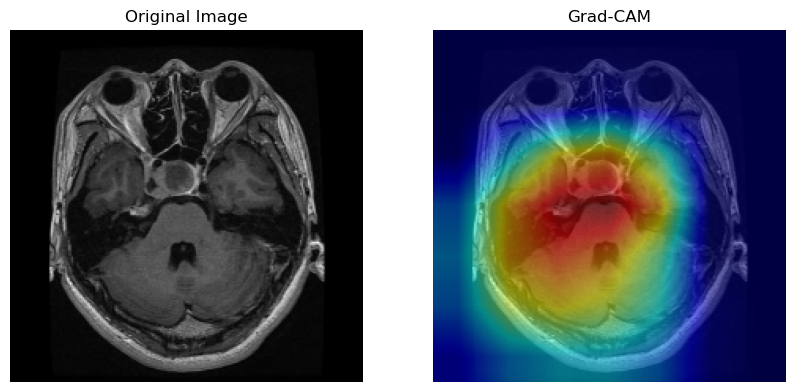

Predicted: no


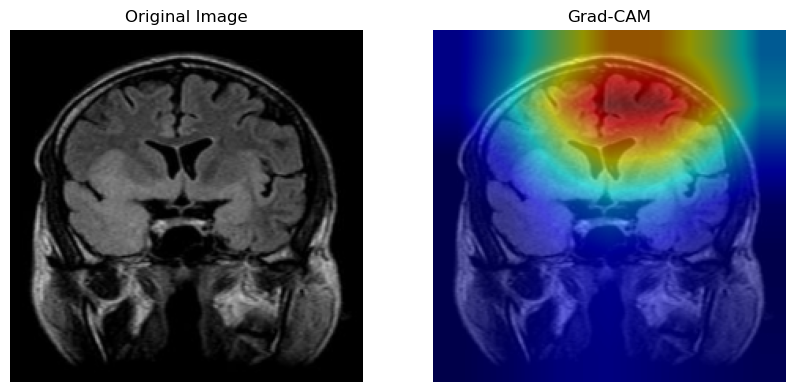

'no'

In [12]:
# 2 test cases with yes and no
image_path1 = r"D:\ml\brain tumor new data\train\yes\p (30).jpg"  #yes
image_path2 = r"D:\ml\brain tumor new data\test\no\image(5).jpg"    #no
predict_image(model, image_path1, preprocess, target_layer)
predict_image(model, image_path2, preprocess, target_layer)
